In [25]:
# IMPORTS

import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf
import lightkurve as lk

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import astropy
from astropy.timeseries import TimeSeries


['lightcurve_2MASSJ20494917+4410462.txt', 'lightcurve_2MASSJ20513057+4403449.txt', 'lightcurve_LkHa146.txt', 'lightcurve_V1598Cyg.txt', 'lightcurve_V1706Cyg.txt']


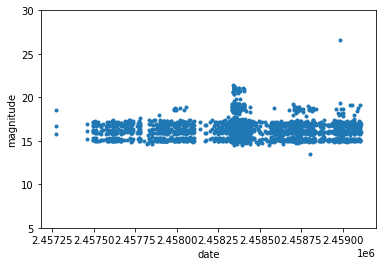

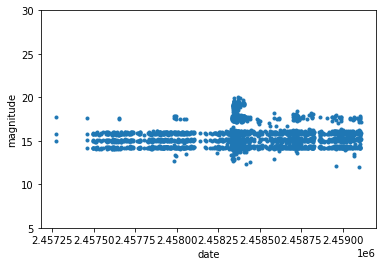

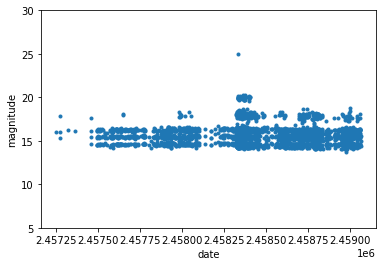

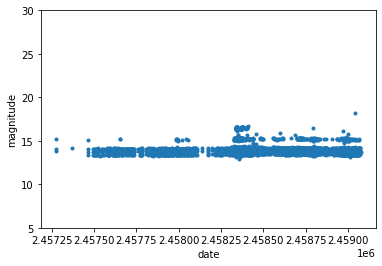

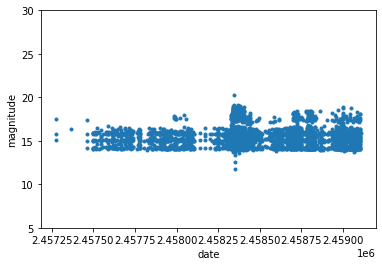

In [26]:
# FETCH DATA

lc_exo_folder = "./LIGHTCURVES/" # create one for lightcurves with no exoplanets
lc_exo_dir = os.listdir(lc_exo_folder)
lc_exo_plots = "./lightcurvePLOTS/has_exoplanets/"
print(lc_exo_dir)

# PLOT AND SAVE TO FOLDER

for x in lc_exo_dir:
    lc_exo_df = pd.read_csv(os.path.join(lc_exo_folder, x), comment="#", delimiter=" ")
    mag = lc_exo_df["calibrated_magnitude"]
    date = lc_exo_df["date"]
    plt.plot(date,mag,".",linewidth=0)
    plt.ylim([5,30])
    plt.xlabel("date")
    plt.ylabel("magnitude")
    plt.savefig(os.path.abspath(lc_exo_plots) + "/lc_exo_" + str(lc_exo_dir.index(x)) + ".png")
    plt.show()


In [33]:
# USER INPUT TARGET STAR AND MISSION

target = str(input("Enter your target: "))
mission = str(input("Enter mission: "))
quart = input("Enter quarter (Kepler) or sector (TESS), A for all, M for multiple: ")

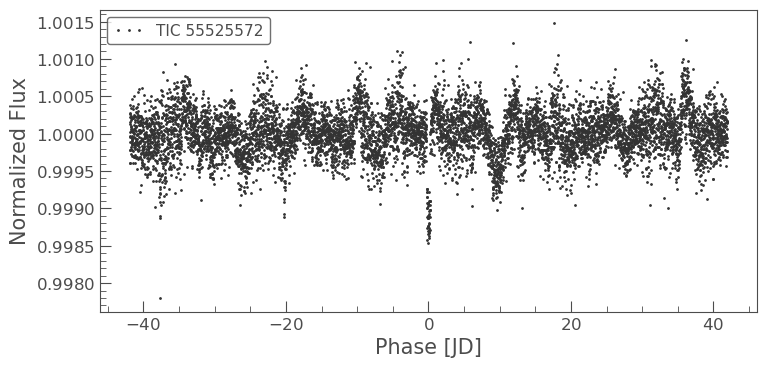

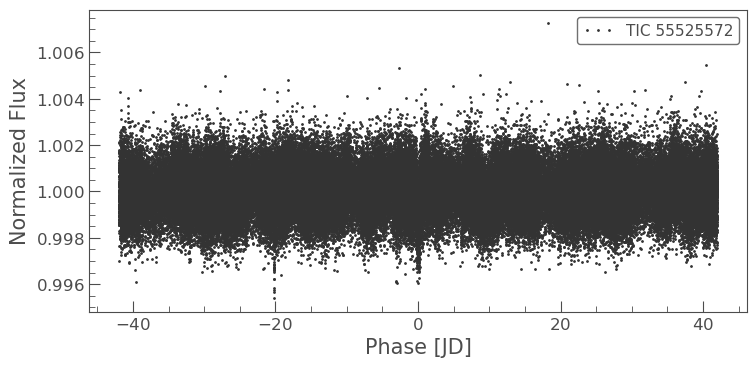

In [41]:
# FIND, PLOT AND SAVE TEST DATA

test_plot_dir = "./testPLOTS/"

if quart == "A" or quart == "a" or quart == "all" or quart == "All":
    testsearch = lk.search_lightcurve(target,author=mission)
    lc_test = testsearch.download()

elif quart == "M":
    q1 = int(input("Enter first quarter/sector: "))
    q2 = int(input("Enter last quarter/sector: "))
    testsearch = lk.search_lightcurve(target,author=mission)[q1:q2]
    lc_test = testsearch.download_all().stitch()

else:
    if mission == "Kepler":
        testsearch = lk.search_lightcurve(target,author=mission,quarter=int(quart))
    elif mission == "SPOC":
        testsearch = lk.search_lightcurve(target,author=mission,sector=int(quart))
    lc_test = testsearch.download()

period = 83.8979
t0 = 2125.847

lc_test_phased = lc_test.fold(period=period,epoch_time=t0)

bin_time = 15/24/60
lc_test_binned = lc_test_phased.bin(bin_time)

lc_test_binned.plot(linewidth=0,marker=".")
plt.savefig(os.path.abspath(test_plot_dir) + "/lc_testplot.png")
plt.show()

In [ ]:
# CREATE TRAIN AND TEST DATASETS

train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_ds = train.flow_from_directory(
    os.path.abspath(lc_exo_plots),
    target_size=(150,150), # maybe change target size? check file structure is correct
    batch_size = 32,
    class_mode = 'binary')

test_ds = test.flow_from_directory(
    os.path.abspath(test_plot_dir),
    target_size=(150,150),
    batch_size = 32,
    class_mode = 'binary')

# BUILD CNN MODEL

model = keras.Sequential()

model.add(keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(64,(3,3),activation="relu"))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(128,(3,3),activation="relu"))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(128,(3,3),activation="relu"))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512,activation="relu"))

model.add(keras.layers.Dense(1,activation="sigmoid"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

# TRAIN DATA

model.fit_generator(
    train_ds,
    steps_per_epoch = 250,
    epochs = 10,
    validation_data = test_ds
)

# PREDICTIONS (FUNCTION)

def predictExo(filename):
    img = image.load_img(filename,target_size=(150,150))
    plt.imshow(img)

    Y = image.img_to_array(img)
    X = np.expand_dims(Y,axis=0)

    val = model.predict(X)
    print(val)

    if val == 1:
        plt.xlabel("Exoplanet detected!",fontsize=30)
    elif val == 0:
        plt.xlabel("No exoplanet detected.",fontsize=30)

predictExo(lc_test)